<h1>РК2, вариант 2, Вешторт Ева, ИУ5-62Б</h1>

Задание:

Для заданного набора данных (load_wine) постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения моделей используйте методы 1 и 2 (Метод опорных векторов и случайный лес). Оцените качество моделей на основе подходящих метрик качества (не менее двух метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей? Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.

Решать будем задачу классификации (т.к. данный датасет подразумевает ее)

In [1]:
from sklearn.datasets import load_wine
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

In [3]:
df.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

Пропуски отсутствуют, все данные числовые - препроцессинг в данном случае не нужен

In [5]:
X = df.drop(columns=['target'])
y = df['target']

In [6]:
y.value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

Есть небольшой дисбаланс классов, для кросс-валидации будем использовать метрику F1

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

param_grid_svm = [
    {
        'svm__kernel': ['linear'],
        'svm__C': [0.1, 0.5, 1, 2, 5, 10]
    },
    {
        'svm__kernel': ['rbf'],
        'svm__C': [0.1, 0.5, 1, 2, 5, 10],
        'svm__gamma': [0.01, 0.05, 0.1, 0.2, 0.5, 'scale']
    }
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=cv, scoring='f1_weighted')
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC())]),
             param_grid=[{'svm__C': [0.1, 0.5, 1, 2, 5, 10],
                          'svm__kernel': ['linear']},
                         {'svm__C': [0.1, 0.5, 1, 2, 5, 10],
                          'svm__gamma': [0.01, 0.05, 0.1, 0.2, 0.5, 'scale'],
                          'svm__kernel': ['rbf']}],
             scoring='f1_weighted')

In [9]:
grid_svm.best_params_

{'svm__C': 0.5, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}

In [10]:
svm = grid_svm.best_estimator_
y_pred_svm = svm.predict(X_test)

In [11]:
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [10, 25, 50, 100, 200],
    'rf__max_depth': [None, 1, 2, 5, 10, 100, 150, 200],
    'rf__max_features': ['sqrt', 'log2']
}

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=cv, scoring='f1_weighted')
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rf__max_depth': [None, 1, 2, 5, 10, 100, 150, 200],
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__n_estimators': [10, 25, 50, 100, 200]},
             scoring='f1_weighted')

In [12]:
grid_rf.best_params_

{'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__n_estimators': 25}

In [13]:
rf = grid_rf.best_estimator_
y_pred_rf = rf.predict(X_test)

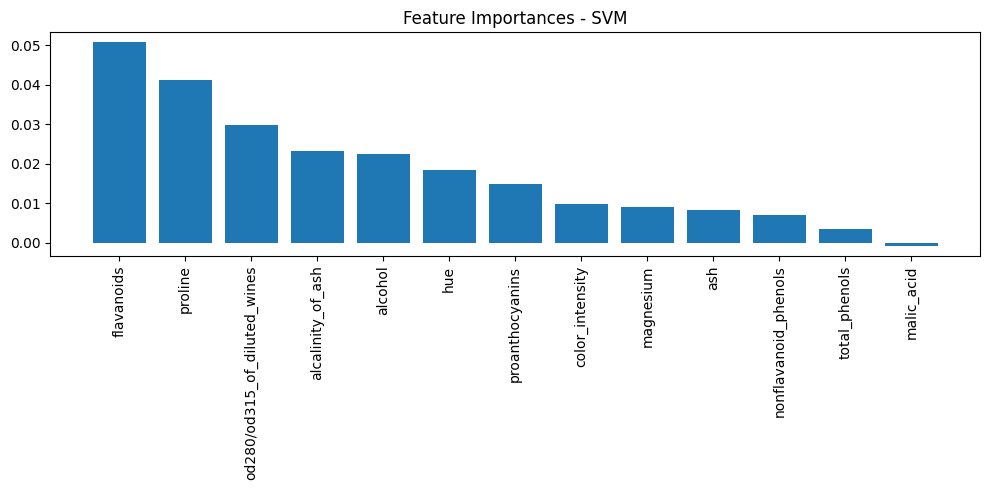

In [14]:
feature_names = load_wine().feature_names

result = permutation_importance(svm, X_train, y_train, scoring='f1_weighted', n_repeats=10, random_state=42)
importances_svm = result.importances_mean

indices_svm = np.argsort(importances_svm)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(importances_svm)), importances_svm[indices_svm], align='center')
plt.xticks(range(len(importances_svm)), [feature_names[i] for i in indices_svm], rotation=90)
plt.title("Feature Importances - SVM")
plt.tight_layout()
plt.show()

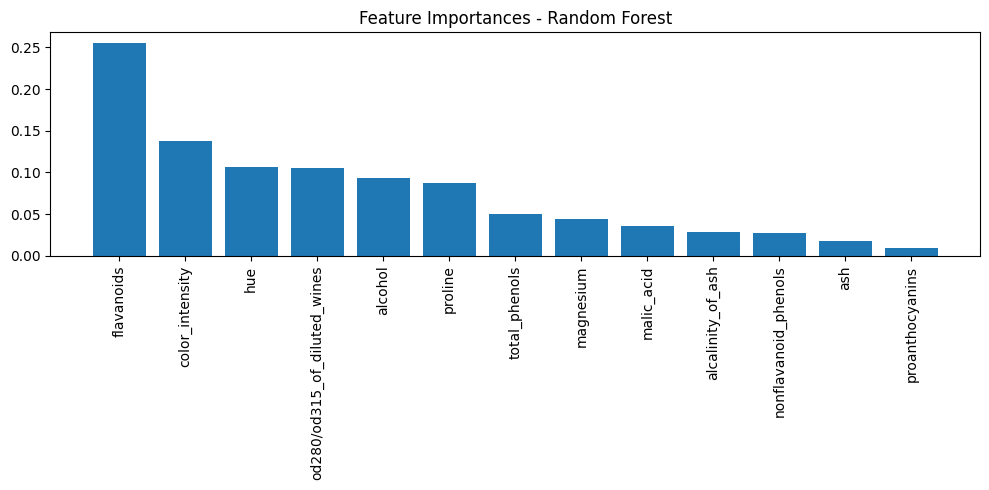

In [15]:
importances_rf = rf.named_steps['rf'].feature_importances_

indices_rf = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(importances_rf)), importances_rf[indices_rf], align='center')
plt.xticks(range(len(importances_rf)), [feature_names[i] for i in indices_rf], rotation=90)
plt.title("Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

In [16]:
svm_acc = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f"SVM: Accuracy = {svm_acc:.3f}, F1-score = {svm_f1:.3f}")
print(f"Random Forest: Accuracy = {rf_acc:.3f}, F1-score = {rf_f1:.3f}")

SVM: Accuracy = 1.000, F1-score = 1.000
Random Forest: Accuracy = 1.000, F1-score = 1.000


**Вывод**

* Данные хорошо подготовлены: отсутствуют пропуски, признаки числовые — всё это делает задачу благоприятной для классических моделей ML.
* Обе модели показали высокое качество классификации. Оценка проводилась при помощи метрик accuracy и F1. Accuracy была выбрана из-за легкости интерпретации - дисбаланс классов в данной задаче не настолько сильный, чтобы метрика была неприменимой, но, так как дисбаланс все же есть, в качестве второй метрики использовали F1.
* Наиболее важным признаком в обеих моделях оказался признак flavonoids (как мы видели в первом РК при корреляционном анализе - этот признак имеет наибольшую корреляцию с целевым)